# Dataset 

In [1]:
import sys
sys.path.append('../../datasets/')
from prepare_sequences import prepare, germanBats
import matplotlib.pyplot as plt

classes = germanBats

In [2]:
num_bands = 257
patch_len = 44                               # = 250ms ~ 25ms
patch_skip = patch_len / 2                   # = 150ms ~ 15ms

resize = None

mode = 'pick_random'
options = {
    'seq_len': 60,                            # = 500ms with ~ 5 calls
    'seq_skip': 15,
    'min_len': 8,
    'max_len': 64,
    'overlap_coeff': 4.0,
}

X_train, Y_train, X_test, Y_test, X_val, Y_val = prepare("../../datasets/prepared.h5", classes, patch_len, patch_skip,
                                                         options, mode, resize)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:53<00:00,  2.99s/it]


In [3]:
print("Total sequences:", len(X_train) + len(X_test) + len(X_val))
print(X_train.shape, Y_train.shape)

Total sequences: 32289
(18972, 64, 44, 257) (18972,)


# Model

Sequence -> pos. encoding -> Transformer (CLS)

In [4]:
import time
import datetime
import numpy as np
import tqdm
import torch
import torch.nn as nn
import math
from torch.cuda.amp import autocast
from torch.utils.data import TensorDataset, DataLoader

sys.path.append('../addons/')
from sam import SAM
import einops
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

In [5]:
use_mixedprecision = False
use_sampler = False
use_reduceonplateu = False
use_cosinescheduler = True
use_sam = True

In [6]:
class PositionalEncoding(nn.Module):
    """
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, d_model, max_len):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return x

In [7]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

In [8]:
class Net(nn.Module):
    """
    Classifier based on a pytorch TransformerEncoder.
    """

    def __init__(
        self,
        max_len,
        patch_dim,
        d_model,
        num_classes,
        nhead=8,
        dim_feedforward=2048,
        num_layers=6,
        dropout=0.1,
        classifier_dropout=0.1,
    ):

        super().__init__()

        # assert d_model % nhead == 0, "nheads must divide evenly into d_model"

        #self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        self.to_patch_embedding = nn.Sequential(
            nn.Flatten(start_dim=2, end_dim=3),
            nn.Linear(patch_dim, d_model),
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_encoder = nn.Parameter(torch.randn(1, max_len + 1, d_model))

        self.dropout = nn.Dropout(p=dropout)
        
        self.transformer_encoder = Transformer(
            dim=d_model,
            depth=num_layers,
            heads=nhead,
            dim_head=16,
            mlp_dim=dim_feedforward,
            dropout=dropout)
        
        self.classifier = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, num_classes))
        
        self.d_model = d_model

    def forward(self, x):       
        x = self.to_patch_embedding(x)
        
        cls = einops.repeat(self.cls_token, '1 n d -> b n d', b=x.shape[0])
        x = torch.cat((cls, x), dim=1)
        x += self.pos_encoder
        
        x = self.dropout(x)
        x = self.transformer_encoder(x)
        
        x = x[:, 0]
        x = self.classifier(x)
        return x

In [9]:
def train_epoch(model, epoch, criterion, optimizer, scheduler, dataloader, device):
    model.train()
    
    running_loss = 0.0
    running_corrects = 0
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    for batch, (inputs, labels) in enumerate(tqdm.tqdm(dataloader)):
        # Transfer Data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)
         
        # Clear the gradients
        optimizer.zero_grad()
        
        with autocast(enabled=use_mixedprecision):
            # Forward Pass
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            # Compute Loss
            loss = criterion(outputs, labels)
        
        # Calculate gradients
        loss.backward()
        
        # Update Weights
        if use_sam:
            optimizer.first_step()
            criterion(model(inputs), labels).backward()
            optimizer.second_step()
        else:
            optimizer.step()
        
        # Calculate Loss
        running_loss += loss.item() * inputs.size(0)
        running_corrects += (predictions == labels).sum().item()
    
        # Perform learning rate step
        if use_cosinescheduler:
            scheduler.step(epoch + batch / num_batches)
            
    epoch_loss = running_loss / num_samples
    epoch_acc = running_corrects / num_samples
    
    return epoch_loss, epoch_acc

In [10]:
def test_epoch(model, epoch, criterion, optimizer, dataloader, device):
    model.eval()
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0

        for batch, (inputs, labels) in enumerate(tqdm.tqdm(dataloader)):
            # Transfer Data to GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear the gradients
            optimizer.zero_grad()

            # Forward Pass
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            # Compute Loss
            loss = criterion(outputs, labels)

            # Calculate Loss
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (predictions == labels).sum().item()

        epoch_loss = running_loss / num_samples
        epoch_acc = running_corrects / num_samples
    
    return epoch_loss, epoch_acc

In [11]:
from torchsampler import ImbalancedDatasetSampler

max_len = 64
batch_size = 64
epochs = 25
lr = 1e-3
warmup_epochs = 5
d_model = 512
nhead = 2
dim_feedforward = 32
num_layers = 2
dropout = 0.3
classifier_dropout = 0.3
    
train_data = TensorDataset(torch.Tensor(X_train), torch.from_numpy(Y_train))
test_data = TensorDataset(torch.Tensor(X_test), torch.from_numpy(Y_test))
val_data = TensorDataset(torch.Tensor(X_val), torch.from_numpy(Y_val))

if use_sampler:
    train_loader = DataLoader(train_data, sampler=ImbalancedDatasetSampler(train_data), batch_size=batch_size)
    test_loader = DataLoader(test_data, sampler=ImbalancedDatasetSampler(test_data), batch_size=batch_size)
    val_loader = DataLoader(val_data, sampler=ImbalancedDatasetSampler(val_data), batch_size=batch_size)
else:
    train_loader = DataLoader(train_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)
    val_loader = DataLoader(val_data, batch_size=batch_size)

In [12]:
model = Net(
    max_len=max_len,
    patch_dim=resize[0]*resize[1] if resize is not None else patch_len * num_bands, # patch_len * num_bands, # 44 * 257 = 11,308
    d_model=d_model,
    num_classes=len(list(classes)),
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    num_layers=num_layers,
    dropout=dropout,
    classifier_dropout=classifier_dropout,
)
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids=[0, 1])
model.to(device)
print(device)

cuda:0


In [13]:
import wandb

wandb_config = {
    "epochs": epochs,
    "lr": lr,
    "batch_size": batch_size,
    "warmup_epochs": warmup_epochs,
    "d_model": d_model,
    "nhead": nhead,
    "dim_feedforward": dim_feedforward,
    "num_layers": num_layers,
    "dropout": dropout,
    "classifier_dropout": classifier_dropout,
    
    "use_mixedprecision": use_mixedprecision,
    "use_sampler": use_sampler,
    "use_reduceonplateu": use_reduceonplateu,
    "use_cosinescheduler": use_cosinescheduler,
    "use_sam": use_sam
}

wandb.init(project="BAT-1", entity="frankfundel", config=wandb_config)

criterion = nn.CrossEntropyLoss() # has softmax in it


if use_sam:
    base_optimizer = torch.optim.SGD
    optimizer = SAM(model.parameters(), base_optimizer, lr=lr, momentum=0.9)
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
scheduler = None
if use_cosinescheduler:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=warmup_epochs)
if use_reduceonplateu:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
min_val_loss = np.inf

torch.autograd.set_detect_anomaly(True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: frankfundel (use `wandb login --relogin` to force relogin)


In [14]:
for epoch in range(epochs):
    end = time.time()
    print(f"==================== Starting at epoch {epoch} ====================", flush=True)
    
    train_loss, train_acc = train_epoch(model, epoch, criterion, optimizer, scheduler, train_loader, device)
    print('Training loss: {:.4f} Acc: {:.4f}'.format(train_loss, train_acc), flush=True)
    
    val_loss, val_acc = test_epoch(model, epoch, criterion, optimizer, val_loader, device)
    print('Validation loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc), flush=True)
    
    if use_reduceonplateu:
        scheduler.step(val_loss)
    
    wandb.log({
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
    })
    
    if min_val_loss > val_loss:
        print('val_loss decreased, saving model', flush=True)
        min_val_loss = val_loss
         
        # Saving State Dict
        torch.save(model.state_dict(), 'bat_1.pth')

==================== Starting at epoch 0 ====================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [04:08<00:00,  1.19it/s]

Training loss: 2.3688 Acc: 0.2572



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:40<00:00,  1.89it/s]

Validation loss: 1.5422 Acc: 0.4719
val_loss decreased, saving model


==================== Starting at epoch 1 ====================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [02:56<00:00,  1.68it/s]

Training loss: 1.2985 Acc: 0.5557



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:20<00:00,  3.82it/s]

Validation loss: 1.2048 Acc: 0.5761
val_loss decreased, saving model


==================== Starting at epoch 2 ====================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [03:00<00:00,  1.64it/s]

Training loss: 1.0067 Acc: 0.6448



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:23<00:00,  3.30it/s]

Validation loss: 1.1279 Acc: 0.6074
val_loss decreased, saving model
==================== Starting at epoch 3 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [02:55<00:00,  1.69it/s]

Training loss: 0.8740 Acc: 0.6951



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:20<00:00,  3.67it/s]

Validation loss: 1.1187 Acc: 0.6153
val_loss decreased, saving model
==================== Starting at epoch 4 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [02:59<00:00,  1.65it/s]

Training loss: 0.8151 Acc: 0.7184



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.82it/s]

Validation loss: 1.1097 Acc: 0.6168
val_loss decreased, saving model
==================== Starting at epoch 5 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [03:06<00:00,  1.60it/s]

Training loss: 0.8349 Acc: 0.7077



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:16<00:00,  4.70it/s]

Validation loss: 1.1370 Acc: 0.6235


==================== Starting at epoch 6 ====================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [03:06<00:00,  1.59it/s]

Training loss: 0.6619 Acc: 0.7690



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:20<00:00,  3.84it/s]

Validation loss: 1.1486 Acc: 0.6414
==================== Starting at epoch 7 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [02:51<00:00,  1.73it/s]

Training loss: 0.5183 Acc: 0.8263



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:18<00:00,  4.28it/s]

Validation loss: 1.1963 Acc: 0.6475
==================== Starting at epoch 8 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [03:07<00:00,  1.58it/s]

Training loss: 0.4177 Acc: 0.8671



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:20<00:00,  3.78it/s]

Validation loss: 1.1535 Acc: 0.6483
==================== Starting at epoch 9 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [02:53<00:00,  1.71it/s]

Training loss: 0.3715 Acc: 0.8923



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:21<00:00,  3.59it/s]

Validation loss: 1.1806 Acc: 0.6497
==================== Starting at epoch 10 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [02:21<00:00,  2.10it/s]

Training loss: 0.4305 Acc: 0.8610



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:09<00:00,  8.46it/s]

Validation loss: 1.2532 Acc: 0.6444
==================== Starting at epoch 11 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [02:17<00:00,  2.16it/s]

Training loss: 0.3326 Acc: 0.8962



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:11<00:00,  6.93it/s]

Validation loss: 1.3513 Acc: 0.6463
==================== Starting at epoch 12 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [02:17<00:00,  2.16it/s]

Training loss: 0.2514 Acc: 0.9272



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:08<00:00,  8.79it/s]

Validation loss: 1.3155 Acc: 0.6528
==================== Starting at epoch 13 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [02:06<00:00,  2.35it/s]

Training loss: 0.1941 Acc: 0.9475



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:12<00:00,  5.97it/s]

Validation loss: 1.3192 Acc: 0.6568
==================== Starting at epoch 14 ====================



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 217/297 [01:39<00:36,  2.18it/s]


KeyboardInterrupt: 

In [15]:
model.load_state_dict(torch.load('bat_1.pth'))
#compiled_model = torch.jit.script(model)
#torch.jit.save(compiled_model, 'bat_1.pt')

<All keys matched successfully>

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

Y_pred = []
Y_true = []
corrects = 0

model.eval()

# iterate over test data
for inputs, labels in tqdm.tqdm(test_loader):
    output = model(inputs.cuda()) # Feed Network

    output = (torch.max(output, 1)[1]).data.cpu().numpy()
    Y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    Y_true.extend(labels) # Save Truth

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [00:36<00:00,  3.66it/s]


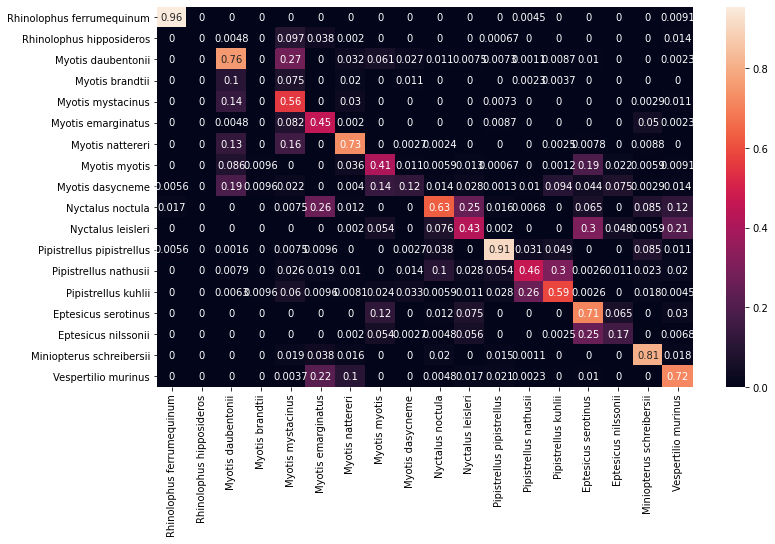

In [17]:
# Build confusion matrix
cf_matrix = confusion_matrix(Y_true, Y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=-1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('bat_1_cf.png')

In [18]:
from sklearn.metrics import f1_score
corrects = np.equal(Y_pred, Y_true).sum()
test_acc = corrects/len(Y_pred)
f1 = f1_score(Y_true, Y_pred, average=None).mean()
print("Test accuracy:", test_acc)
print("F1-score:", f1)

Test accuracy: 0.6276633734079277
F1-score: 0.50817670219019


In [19]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

6037074


In [20]:
wandb.log({
    "test_acc": test_acc,
    "f1_score": f1,
    "num_params": pytorch_total_params,
})

In [21]:
wandb.finish()

f1_score,▁
num_params,▁
test_acc,▁
train_acc,▁▄▅▅▆▆▆▇▇▇▇▇██
train_loss,█▅▄▃▃▃▃▂▂▂▂▁▁▁
val_acc,▁▅▆▆▆▇▇███████
val_loss,█▃▁▁▁▁▂▂▂▂▃▅▄▄
f1_score,0.50818
num_params,6037074
test_acc,0.62766
train_acc,0.9475
